# Claim frequency and severity regression

We will now predict claim frequency and severity in the MTPL data with a neural network.

In [1]:
# load libs
from IPython.display import display, Math, Latex
import tensorflow as tf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# load data using separator to correctly parse from .txt
df = pd.read_csv(os.path.join(os.getcwd(),"data\PC_data.txt"),  sep=r"\s+")

In [3]:
# column names to smaller case
df.columns = map(str.lower, df.columns)

In [4]:
# rename exp to expo
df.rename(columns={'exp':'expo'}, inplace = True); df.head()

,id,nclaims,amount,avg,expo,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
0,1,1,1618.001036,1618.001036,1.000000,TPL,gasoline,private,N,male,50,5,12,77,1000,BRUSSEL,4.355223,50.845386
1,2,0,0.000000,NaN,1.000000,PO,gasoline,private,N,female,64,5,3,66,1000,BRUSSEL,4.355223,50.845386
2,3,0,0.000000,NaN,1.000000,TPL,diesel,private,N,male,60,0,10,70,1000,BRUSSEL,4.355223,50.845386
3,4,0,0.000000,NaN,1.000000,TPL,gasoline,private,N,male,77,0,15,57,1000,BRUSSEL,4.355223,50.845386
4,5,1,155.974606,155.974606,0.046575,TPL,gasoline,private,N,female,28,9,7,70,1000,BRUSSEL,4.355223,50.845386


In [5]:
# train/test split using sklearn
train, test = train_test_split(df, test_size=0.25); print(f'train size:{train.shape}, test size:{test.shape}')

train size:(122423, 18), test size:(40808, 18)


In [6]:
# Reshuffling of the training observations
train = train.sample(frac = 1); print(f'train size:{train.shape}')

train size:(122423, 18)


Let's start with a model with only an intercept:

In [7]:
# initialize NN
nn_freq_intercept = tf.keras.models.Sequential()

In [8]:
# add fully connected layer using exponential actiavation function
nn_freq_intercept.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))

In [9]:
# choince of the optimizer and loglikelihood to maximize
nn_freq_intercept.compile(optimizer = 'RMSprop', loss = 'poisson')

In [10]:
# Q: how many parameters does this model have?
nn_freq_intercept.count_params()

1

In [11]:
# summary of the structure of the neural netweork
nn_freq_intercept.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [59]:
# create vectors for the input and output
intercept = np.ones(train.shape[0])
counts = np.array(train['nclaims'])
print(f'size of intercept vector: {intercept.shape[0]}, size of counts vector: {counts.shape[0]}')

size of intercept vector: 122423, size of counts vector: 122423


In [60]:
# fit the neural netword
nn_freq_intercept.fit(intercept,
                      counts,
                      epochs = 30,
                      batch_size = 1024,
                      validation_split = 0,
                      verbose = 0)

We compare the results of our neural network with the same model specified as a GLM:

In [61]:
glm_freq_intercept = sm.formula.glm("nclaims ~ 1", data=train, family=sm.families.Poisson()).fit(); glm_freq_intercept.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122422
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48008.
Date:                Tue, 05 Oct 2021   Deviance:                       67655.
Time:                        15:23:30   Pearson chi2:                 1.33e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0855      0.008   -257.206      0.000      -2.101      -2.070
==============================================================================
"""

In [63]:
# comparing the estimated parameter (difference reflects a different optimization technique)
print(f'NN weights:{nn_freq_intercept.get_weights()[0][0][0]}, \nGLM coefficients:{glm_freq_intercept.params[0]}')

NN weights:-2.089312791824341, 
GLM coefficients:-2.0855291546509833


### Your Turn!

In [64]:
# Q1: adapt this code to replicate a binomial GLM with a logit link function. Add accuracy as a metric in your model.
exercize_nn = tf.keras.models.Sequential()
exercize_nn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid', input_shape = (1,), use_bias = False))
exercize_nn.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [65]:
# Q2: fit your neural network
exercize_nn.fit(intercept,
                      counts > 0,
                      epochs = 40,
                      batch_size = 1024,
                      validation_split = 0,
                      verbose = 0)

In [68]:
# Q3: compare with GLM
exercize_glm = sm.formula.glm("nclaims < 1 ~ 1", # it must be fitted this way or 0/1 labels get switched
                            data=train, 
                            family=sm.families.Binomial(sm.families.links.logit())).fit();
    
print(f'NN weights:{exercize_nn.get_weights()[0][0][0]}, \nGLM coefficients:{exercize_glm.params[0]}')

NN weights:-2.063455104827881, 
GLM coefficients:-2.0671407011235106


In [ ]:
exercize_glm.summary()

In [74]:
exercize_glm.predict()

array([0.11233183, 0.11233183, 0.11233183, ..., 0.11233183, 0.11233183,
       0.11233183])

In [75]:
# Q3: compare prediction
np.unique(np.round(exercize_glm.predict(),5)) # PERCHE' 1 - exercize_glm.predict()?

array([0.11233])

In [76]:
np.unique(np.round(exercize_nn.predict(x = intercept),5))

array([0.1127], dtype=float32)

In [78]:
# END OF THE EXERCIZE

### Taking exposure into account in a neural network

Classical GLM including exposure:

In [81]:
glm_offset = sm.formula.glm("nclaims ~ ageph", 
                            data=train, 
                            offset = np.log(train.expo),
                            family=sm.families.Poisson()).fit(); 
glm_offset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122421
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47577.
Date:                Tue, 05 Oct 2021   Deviance:                       66792.
Time:                        15:27:56   Pearson chi2:                 1.50e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2396      0.026    -46.864      0.000      -1.291      -1.188
ageph         -0.0160      0.001    -27.930      0.000      -0.017      -0.015
==============================================================================
"""

In [82]:
glm_offset.params

Intercept   -1.239626
ageph       -0.015975
dtype: float64

Classical GLM including weights:

In [84]:
glm_weights = sm.formula.glm("nclaims ~ ageph", 
                             data=train, 
                             weights = train.expo, 
                             exposure = train.expo, 
                             family=sm.families.Poisson()).fit(); 
glm_weights.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122421
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47577.
Date:                Tue, 05 Oct 2021   Deviance:                       66792.
Time:                        15:30:07   Pearson chi2:                 1.50e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2396      0.026    -46.864      0.000      -1.291      -1.188
ageph         -0.0160      0.001    -27.930      0.000      -0.017      -0.015
==============================================================================
"""

In [96]:
glm_weights.params

Intercept   -1.239626
ageph       -0.015975
dtype: float64

The specification structure of the neural network remains the same:

In [97]:
# neural network architecture specification
nn_freq_exposure = tf.keras.models.Sequential()
nn_freq_exposure.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))
nn_freq_exposure.compile(optimizer = 'RMSprop', loss = 'poisson')

In [98]:
# create a vector with exposure values (pd.Series must be converted to pd.array due to compatibility reasons with fit() method)
exposure = np.array(train['expo'])

In [99]:
# divide claim counts by exposure and use weights
nn_freq_exposure.fit(x = intercept,
                     y = counts/exposure,
                     sample_weight = exposure,
                     epochs = 20,
                     batch_size = 1024,
                     validation_split = 0,
                     verbose = 0)

In [102]:
nn_freq_exposure.get_weights()

[array([[-1.7919232]], dtype=float32)]

In [106]:
# comparing the estimated parameter (difference reflects a different optimization technique)
print(f'NN weights:{nn_freq_exposure.get_weights()[0][0][0]}, \n\nGLM_offset coefficients:{glm_offset.params}, \n\nGLM_weights coefficients:{glm_weights.params}')

NN weights:-1.79192316532135, 

GLM_offset coefficients:Intercept   -1.239626
ageph       -0.015975
dtype: float64, 

GLM_weights coefficients:Intercept   -1.239626
ageph       -0.015975
dtype: float64


### How can we include exposure via an offset term?

In [107]:
# create a vector with ageph (pd.Series must be converted to pd.array due to compatibility reasons with fit() method)
ageph = np.array(train['ageph'])

In [108]:
# neural network architecture specification
nn_freq_ageph = tf.keras.models.Sequential()
nn_freq_ageph.add(tf.keras.layers.BatchNormalization(input_shape = (1,))) # layer_batch_normalization centers and scales the input features
nn_freq_ageph.add(tf.keras.layers.Dense(units = 5, activation = 'tanh'))
nn_freq_ageph.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) # Notice how we set use_bias = TRUE for the intercept.
nn_freq_ageph.compile(optimizer = 'RMSprop', loss = 'poisson')

In [111]:
nn_freq_ageph.fit(ageph,
                 counts/exposure,
                 sample_weight = exposure,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)

In [112]:
nn_freq_ageph.get_weights()

[array([0.58682483], dtype=float32),
 array([0.4486653], dtype=float32),
 array([46.986446], dtype=float32),
 array([219.16087], dtype=float32),
 array([[-0.41990626,  0.3513118 ,  0.2744854 ,  0.00437251,  0.65964603]],
       dtype=float32),
 array([-0.41606426,  0.40605304, -0.3920835 ,  0.40150648,  0.46706387],
       dtype=float32),
 array([[ 0.65044665],
        [-0.81724334],
        [ 1.0437535 ],
        [-0.48028782],
        [-0.6920566 ]], dtype=float32),
 array([-0.38707754], dtype=float32)]

### Applying GAM models

In [113]:
from statsmodels.gam.api import GLMGam, BSplines

In [114]:
x_spline = train['ageph']

In [176]:
bs = BSplines(x_spline, df=[10, 10], degree=[3, 3])

In [177]:
gam_bs = GLMGam.from_formula('nclaims ~ 1', 
                             data=train, 
                             smoother=bs, 
                             family=sm.families.Poisson(sm.families.links.log()),
                             offset = np.log(train.expo)).fit();
gam_bs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                         GLMGam   Df Residuals:                   122413
Model Family:                 Poisson   Df Model:                         9.00
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -47500.
Date:                Tue, 05 Oct 2021   Deviance:                       66638.
Time:                        16:40:40   Pearson chi2:                 1.48e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0596      0.154     -6.892      0.000      -1.361      -0.758
ageph_s0      -0.2392      0.235     -1.018      0.308      -0.700       0.221
ageph_s1      -0.6825      0.135     -5.074      0.000      -0.946      -0.419
ageph_s2      -0.9138      0.173     -5.273      0.000      -1.253      -0.574
ageph_s3      -0.8834      0.153     -5.763      0.000      -1.184      -0.583
ageph_s4      -0.9453      0.164     -5.778      0.000      -1.266      -0.625
ageph_s5      -1.0862      0.160     -6.783      0.000      -1.400      -0.772
ageph_s6      -1.4764      0.196     -7.543      0.000      -1.860      -1.093
ageph_s7      -1.0548      0.278     -3.794      0.000      -1.600      -0.510
ageph_s8      -0.6534      0.501     -1.305      0.192      -1.635       0.328
==============================================================================
"""

In [178]:
gam_bs.fittedvalues

153372    0.166440
144123    0.288133
70929     0.137357
6673      0.141733
151603    0.141414
            ...   
68863     0.125252
25199     0.122734
155674    0.145292
91343     0.009728
75848     0.053720
Length: 122423, dtype: float64

In [179]:
gam_bs.predict(exog = pd.DataFrame(np.ones(train.shape[0])),  exog_smooth = np.array(train['ageph']))

0         0.166440
1         0.288133
2         0.137357
3         0.141733
4         0.141414
            ...   
122418    0.125252
122419    0.135751
122420    0.145292
122421    0.098634
122422    0.129854
Length: 122423, dtype: float64

In [180]:
age = tf.cast(np.array(range(18,96)), tf.float32)
nn_pred = nn_freq_ageph.predict(age)

In [181]:
df = pd.DataFrame({'ageph':np.array(range(18,96)),
                  'inter':np.ones(len(list(range(18,96))), dtype = int)})
gam_pred = gam_bs.predict(exog = pd.DataFrame(np.ones(df.shape[0])),  exog_smooth = np.array(df['ageph']))

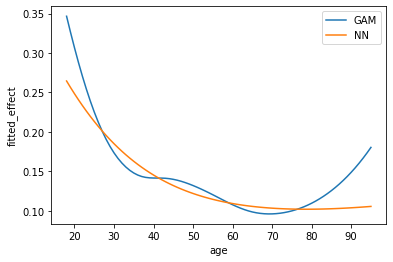

In [182]:
x = np.array(range(18,96))
plt.plot(x, gam_pred, label = "GAM")
plt.plot(x, nn_pred, label = "NN")
plt.xlabel('age')
plt.ylabel('fitted_effect')
plt.legend()
plt.show()

### Adding a skip connection in a neural network

A skip connection allows us to guide the neural net in the right direction and to model adjustments on top of the base predictions, for example obtained via a GLM or GAM. In the actuarial lingo this is called a Combined Actuarial Neural Network (CANN). We are now using Tensorflow Functional API instead of Sequential API.

In [242]:
input_skip = tf.keras.layers.Input(shape = (1,), name = 'skip')
input_nn = tf.keras.layers.Input(shape = (1,), name = 'nn')
norm_nn = tf.keras.layers.BatchNormalization()(input_nn)
dense_1 = tf.keras.layers.Dense(units = 5, activation = 'tanh')(norm_nn)
network = tf.keras.layers.Dense(units = 1, activation = 'linear')(dense_1)

In [243]:
interm = tf.keras.layers.Add()([network, input_skip])

In [244]:
output = tf.keras.layers.Dense(units = 1, 
                               activation = 'exponential', 
                               trainable = True, 
                               name = 'output',
                              )(interm)

In [245]:
cann = tf.keras.models.Model(inputs = [input_nn, input_skip], outputs = output)

In [246]:
cann.compile(optimizer = 'RMSprop', loss = 'poisson')

In [247]:
np.max(gam_bs.predict())

0.34660200830959664

In [248]:
gam_expo = np.log(gam_bs.predict()) + np.log(train['expo']); gam_expo

153372   -1.793120
144123   -1.244332
70929    -1.985173
6673     -1.953810
151603   -1.956066
            ...   
68863    -2.077426
25199    -2.198542
155674   -1.929009
91343    -6.949095
75848    -3.806580
Name: expo, Length: 122423, dtype: float64

In [249]:
cann_input = [np.array(train['ageph']), np.array(gam_expo)]

In [250]:
cann.fit(cann_input,
         counts,
         epochs = 20,
         batch_size = 1024,
         validation_split = 0,
         verbose = 1)

Train on 122423 samples
Epoch 1/20
122423/122423 [==============================] - 1s 6us/sample - loss: 0.4217
Epoch 2/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3969
Epoch 3/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3948
Epoch 4/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3930
Epoch 5/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3913
Epoch 6/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3898
Epoch 7/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3884
Epoch 8/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3872
Epoch 9/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3861
Epoch 10/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3852
Epoch 11/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.

In [251]:
# test output
df = pd.DataFrame({'ageph':np.array(range(18,96)),
                   'skip':np.zeros(len(range(18,96)))}); df.head()

,ageph,skip
0,18,0.0
1,19,0.0
2,20,0.0
3,21,0.0
4,22,0.0


In [252]:
df['cann_pred'] = cann.predict([tf.cast(df.ageph, dtype=tf.float32),tf.cast(df.skip, dtype=tf.float32)]); df.head(5)

,ageph,skip,cann_pred
0,18,0.0,0.517595
1,19,0.0,0.512163
2,20,0.0,0.506744
3,21,0.0,0.501343
4,22,0.0,0.495967


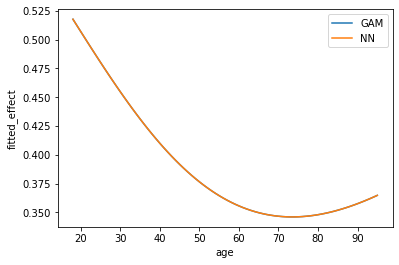

In [253]:
x = df['ageph']
plt.plot(x, df['cann_pred'], label = "GAM")
plt.plot(x, df['cann_pred'], label = "NN")
plt.xlabel('age')
plt.ylabel('fitted_effect')
plt.legend()
plt.show()

In [258]:
a = gam_bs.predict(exog = pd.DataFrame(np.array(range(18,96))),  exog_smooth = np.array(range(18,96)))

In [259]:
# test output
df = pd.DataFrame({'ageph':np.array(range(18,96)),
                   'skip':np.log(a)}); df.head()

,ageph,skip
0,18,-1.059578
1,19,-1.120147
2,20,-1.181903
3,21,-1.244332
4,22,-1.306924


In [260]:
df['cann_pred'] = cann.predict([tf.cast(df.ageph, dtype=tf.float32),tf.cast(df.skip, dtype=tf.float32)]); df.head(5)

,ageph,skip,cann_pred
0,18,-1.059578,0.293769
1,19,-1.120147,0.281426
2,20,-1.181903,0.269406
3,21,-1.244332,0.257787
4,22,-1.306924,0.246631


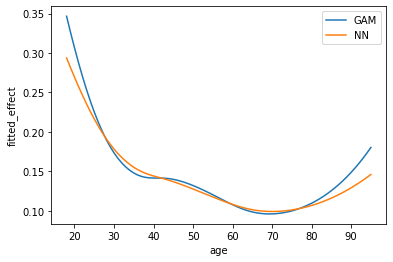

In [263]:
x = df['ageph']
plt.plot(x, np.exp(df['skip']), label = "GAM")
plt.plot(x, df['cann_pred'], label = "NN")
plt.xlabel('age')
plt.ylabel('fitted_effect')
plt.legend()
plt.show()